
Entrenando Red Neuronal para el Cluster 0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cluster 0 - Validation MAE: 3.0021, Validation Loss: 15.0661
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


Modelo del Cluster 0 guardado en: models/model_cluster_0.h5

Entrenando Red Neuronal para el Cluster 1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cluster 1 - Validation MAE: 3.8758, Validation Loss: 22.5013
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Modelo del Cluster 1 guardado en: models/model_cluster_1.h5

Entrenando Red Neuronal para el Cluster 2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cluster 2 - Validation MAE: 2.8333, Validation Loss: 18.1455
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Modelo del Cluster 2 guardado en: models/model_cluster_2.h5


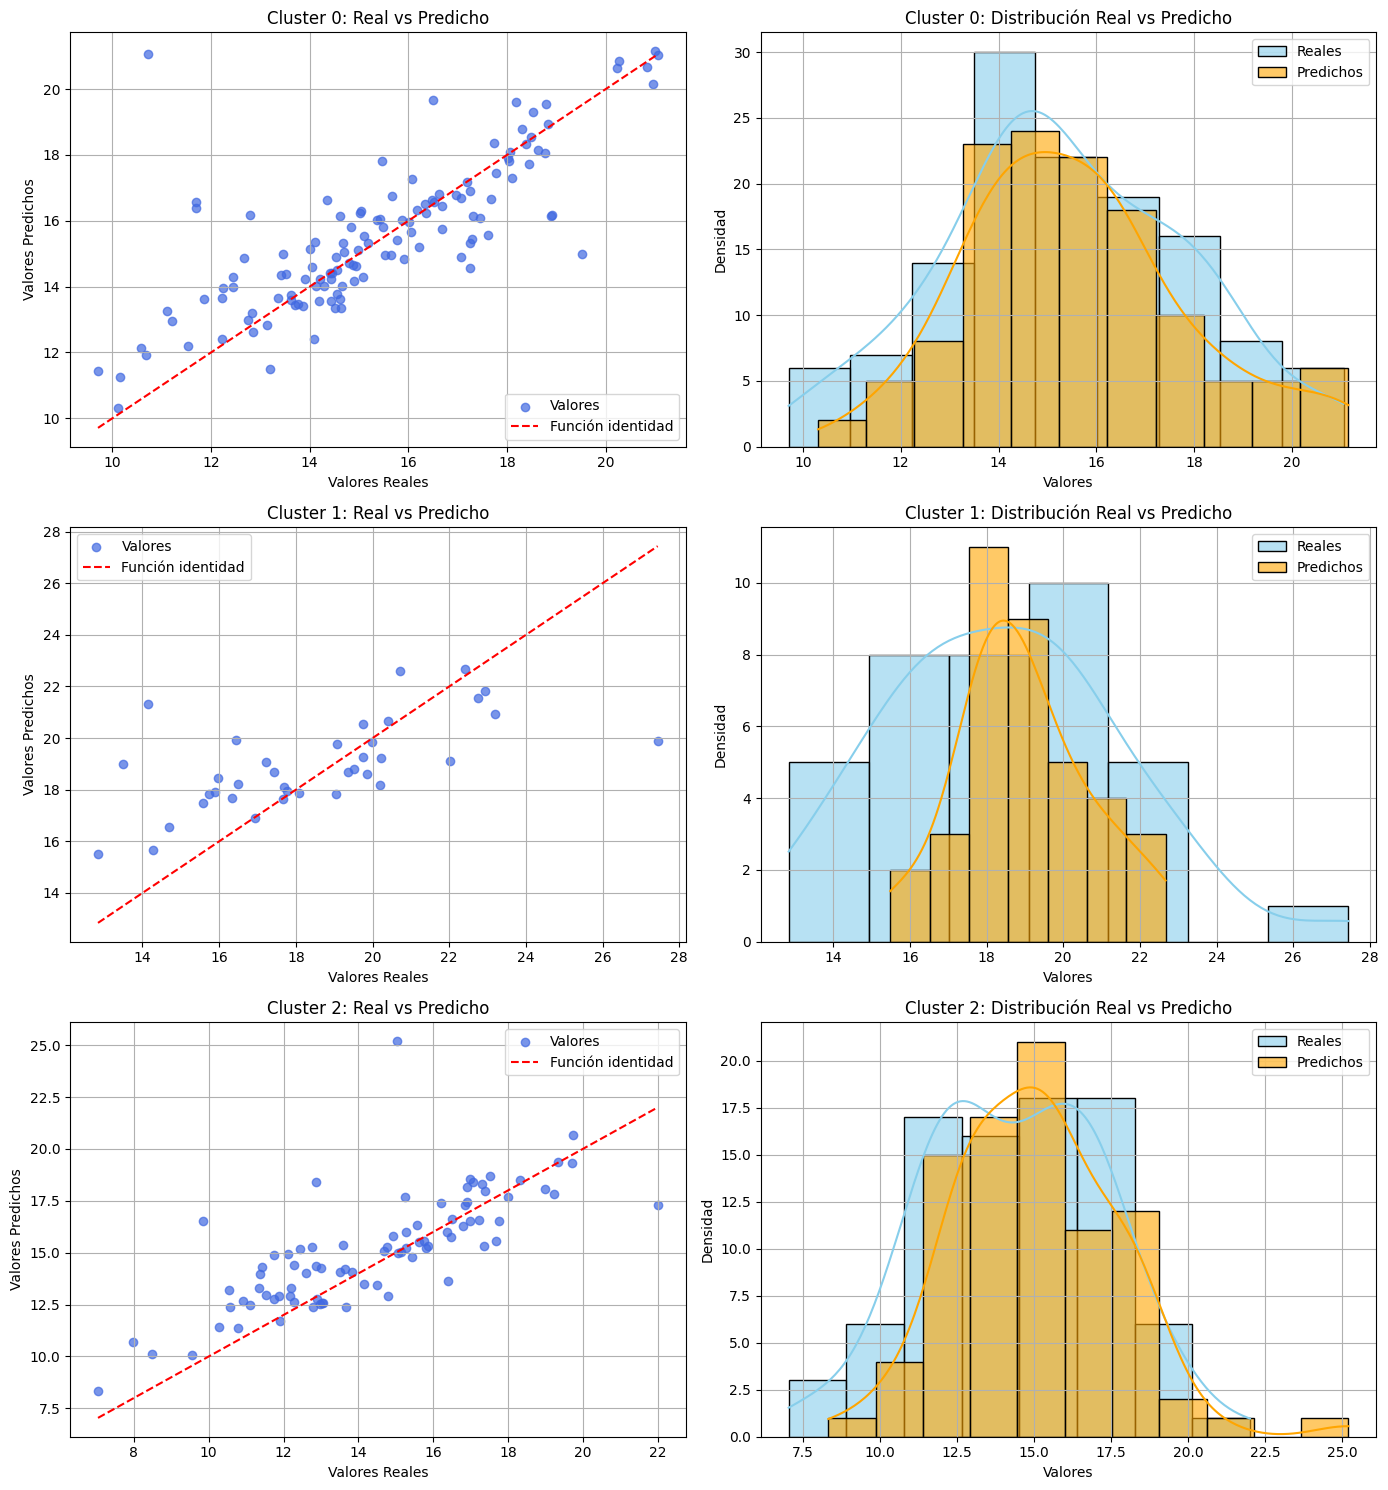

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 1. Cargar y preparar los datos
root = '/Users/michaelcueto/Documents/proyectos/GeologyML23/03_BBDD/data_dureza.csv'
df = pd.read_csv(root)

# Seleccionar características y eliminar NaN
features = ['Cu%','Mo%','AgPPM','AuPPM','Al%','Ca%','Fe%','Mg%','Na%','S%']
target = 'BWI'

# Filtrar y normalizar los datos
df = df[features + [target]].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

# 2. Aplicar KMeans
n_clusters = 3  # Número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

# Crear carpeta para guardar modelos
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# 3. Crear y entrenar una red neuronal para cada cluster
clusters_dict = {}
for cluster in range(n_clusters):
    print(f"\nEntrenando Red Neuronal para el Cluster {cluster}")
    
    # Filtrar el DataFrame para el cluster actual
    cluster_df = df[df['Cluster'] == cluster]
    
    # Definir features (X) y target (y)
    X = cluster_df[features].values
    y = cluster_df[target].values

    # Crear la red neuronal
    model = Sequential([
        Dense(32, input_dim=X.shape[1], activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.02), loss='mse', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(X, y, epochs=500, batch_size=8, validation_split=0.1, verbose=0)

    # Guardar métricas de validación
    val_loss = history.history['val_loss'][-1]
    val_mae = history.history['val_mae'][-1]
    print(f"Cluster {cluster} - Validation MAE: {val_mae:.4f}, Validation Loss: {val_loss:.4f}")

    # Predecir valores
    y_pred = model.predict(X).flatten()

    # Guardar el modelo en la carpeta 'models'
    model_path = os.path.join(models_dir, f"model_cluster_{cluster}.h5")
    model.save(model_path)
    print(f"Modelo del Cluster {cluster} guardado en: {model_path}")

    # Guardar en el diccionario
    clusters_dict[f'Cluster_{cluster}'] = {
        'model': model,
        'X': X,
        'y_real': y,
        'y_pred': y_pred,
        'validation_mae': val_mae,
        'validation_loss': val_loss
    }

# 4. Graficar los resultados
fig, axes = plt.subplots(n_clusters, 2, figsize=(14, 5 * n_clusters))

for cluster in range(n_clusters):
    y_real = clusters_dict[f'Cluster_{cluster}']['y_real']
    y_pred = clusters_dict[f'Cluster_{cluster}']['y_pred']

    # Scatter plot con función identidad
    ax_scatter = axes[cluster, 0]
    ax_scatter.scatter(y_real, y_pred, color='royalblue', alpha=0.7, label='Valores')
    ax_scatter.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Función identidad')
    ax_scatter.set_title(f"Cluster {cluster}: Real vs Predicho")
    ax_scatter.set_xlabel("Valores Reales")
    ax_scatter.set_ylabel("Valores Predichos")
    ax_scatter.legend()
    ax_scatter.grid(True)

    # Distribución de valores reales vs predichos
    ax_dist = axes[cluster, 1]
    sns.histplot(y_real, color='skyblue', kde=True, label='Reales', ax=ax_dist, alpha=0.6)
    sns.histplot(y_pred, color='orange', kde=True, label='Predichos', ax=ax_dist, alpha=0.6)
    ax_dist.set_title(f"Cluster {cluster}: Distribución Real vs Predicho")
    ax_dist.set_xlabel("Valores")
    ax_dist.set_ylabel("Densidad")
    ax_dist.legend()
    ax_dist.grid(True)

# Ajustar diseño de subplots
plt.tight_layout()
plt.show()



In [75]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# 1. Cargar y preparar los datos
root = '/Users/michaelcueto/Documents/proyectos/GeologyML23/03_BBDD/data_dureza.csv'
df = pd.read_csv(root)

# Seleccionar características y eliminar NaN
features = ['Cu%','Mo%','AgPPM','AuPPM','Al%','Ca%','Fe%','Mg%','Na%','S%']
target = 'BWI'

# Filtrar y normalizar los datos
df = df[features + [target]].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

# 2. Aplicar KMeans
n_clusters = 3  # Número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

# Guardar el modelo KMeans y el scaler
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
kmeans_path = os.path.join(models_dir, "kmeans_model.pkl")
scaler_path = os.path.join(models_dir, "scaler.pkl")

import joblib
joblib.dump(kmeans, kmeans_path)
joblib.dump(scaler, scaler_path)

print(f"Modelo KMeans guardado en: {kmeans_path}")
print(f"Scaler guardado en: {scaler_path}")

# 3. Clasificar un dato nuevo
def classify_new_data(new_data, kmeans_model_path, scaler_path):
    """
    Clasifica un nuevo dato en un cluster usando KMeans.
    
    Parameters:
        new_data (list): Lista con las características del nuevo dato.
        kmeans_model_path (str): Ruta del modelo KMeans guardado.
        scaler_path (str): Ruta del scaler guardado.
    
    Returns:
        int: Cluster asignado al nuevo dato.
    """
    # Cargar el modelo y el scaler
    kmeans = joblib.load(kmeans_model_path)
    scaler = joblib.load(scaler_path)
    
    # Convertir el nuevo dato en un array y normalizarlo
    new_data = np.array(new_data).reshape(1, -1)  # Asegurarse de que sea un array 2D
    new_data_scaled = scaler.transform(new_data)
    
    # Predecir el cluster
    cluster = kmeans.predict(new_data_scaled)[0]
    return cluster

# Ejemplo de uso: Clasificar un dato nuevo
new_data = [0.3, 0.1, 20, 0.5, 0.02, 0.03, 0.1, 25, 0.7, 0.2]  # Valores de ejemplo
assigned_cluster = classify_new_data(new_data, kmeans_path, scaler_path)
print(f"El dato nuevo pertenece al Cluster: {assigned_cluster}")


Modelo KMeans guardado en: models/kmeans_model.pkl
Scaler guardado en: models/scaler.pkl
El dato nuevo pertenece al Cluster: 0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(



Entrenando XGBoost Regressor...
Mean Squared Error (MSE): 0.3882
R-squared (R2): 0.9581


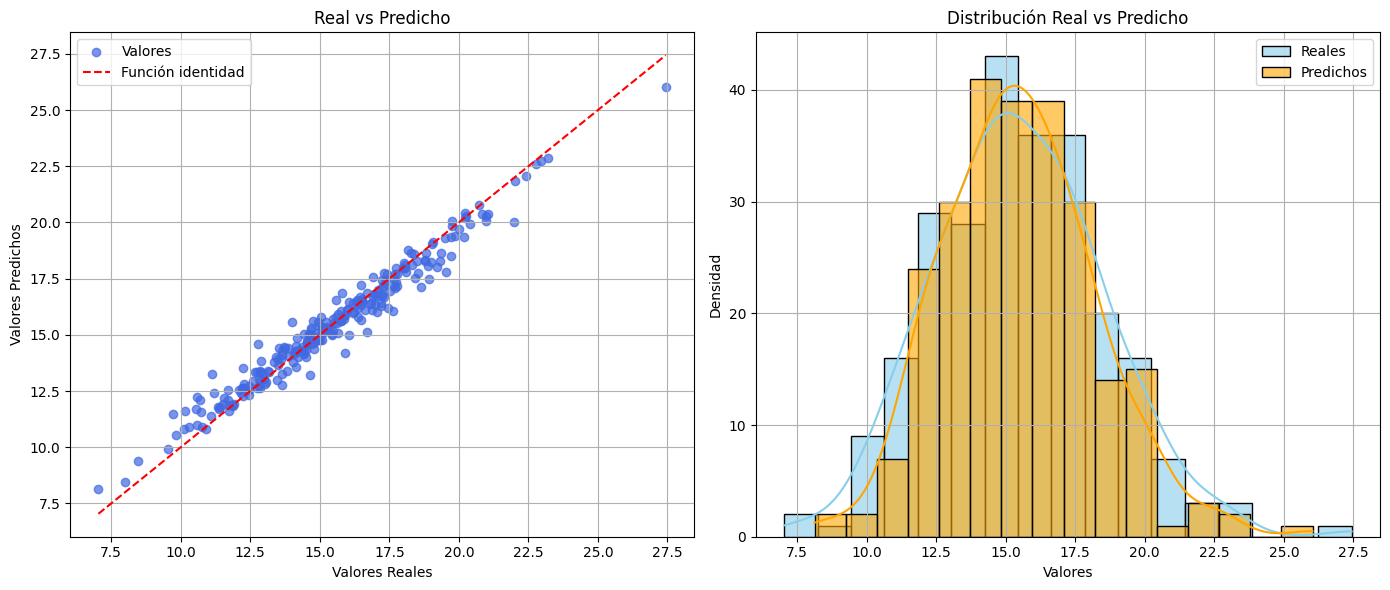

Modelo XGBoost guardado en: models_xgboost/xgboost_model.json


In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Cargar y preparar los datos
root = '/Users/michaelcueto/Documents/proyectos/GeologyML23/03_BBDD/data_dureza.csv'
df = pd.read_csv(root)

# Seleccionar características y eliminar NaN
features = ['Cu%','Mo%','AgPPM','AuPPM','Al%','Ca%','Fe%','Mg%','Na%','S%']
target = 'BWI'

# Filtrar y normalizar los datos
df = df[features + [target]].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

# 2. Definir X (features) y y (target)
X = df[features].values
y = df[target].values

# 3. Entrenar un modelo XGBoost Regressor
print("\nEntrenando XGBoost Regressor...")

# Crear el modelo
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=8, learning_rate=0.5, random_state=42)

# Entrenar el modelo usando todo el dataset
xgb_model.fit(X, y)

# Predecir los valores
y_pred = xgb_model.predict(X)

# Calcular métricas
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# 4. Graficar Resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Real vs Predicho
axes[0].scatter(y, y_pred, color='royalblue', alpha=0.7, label='Valores')
axes[0].plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Función identidad')
axes[0].set_title("Real vs Predicho")
axes[0].set_xlabel("Valores Reales")
axes[0].set_ylabel("Valores Predichos")
axes[0].legend()
axes[0].grid(True)

# Distribución: Reales vs Predichos
sns.histplot(y, color='skyblue', kde=True, label='Reales', ax=axes[1], alpha=0.6)
sns.histplot(y_pred, color='orange', kde=True, label='Predichos', ax=axes[1], alpha=0.6)
axes[1].set_title("Distribución Real vs Predicho")
axes[1].set_xlabel("Valores")
axes[1].set_ylabel("Densidad")
axes[1].legend()
axes[1].grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# 5. Guardar el modelo entrenado
models_dir = "models_xgboost"
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, "xgboost_model.json")
xgb_model.save_model(model_path)
print(f"Modelo XGBoost guardado en: {model_path}")


In [1]:
from model import DurezaModel
root = '/Users/michaelcueto/Documents/proyectos/GeologyML23/03_BBDD/data_dureza.csv'
features = ['Cu%','Mo%','AgPPM','AuPPM','Al%','Ca%','Fe%','Mg%','Na%','S%']
a = DurezaModel(data_path=root, features=features,target= 'SPI', models_dir="models").rfr_model(split=False, save_model=True)
a




Gráfico guardado en: models/real_vs_predicho.png
Scoring Analysis and Graphics
MAE : 23.234771453621473 | R2 : 0.3481623128913121 | EV : 0.38949026685223187


In [6]:
import os
import joblib
root_model = 'models'
file_scaler = 'scaler_rf.pkl'
file_model_spi = 'model_rf_spi.pkl'
file_model_bwi = 'model_rf_bwi.pkl'
file_scaler = os.path.join(root_model, file_scaler)
file_model_spi = os.path.join(root_model, file_model_spi)
file_model_bwi = os.path.join(root_model, file_model_bwi)

In [7]:
scaler_s = joblib.load(file_scaler)
model_spi = joblib.load(file_model_spi)
model_bwi = joblib.load(file_model_bwi)

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_rf_spi.pkl'

In [8]:
x = [[0.3, 0.1, 20, 0.5, 0.02, 0.03, 0.1, 25, 0.7, 0.2]]
x_test = scaler_s.transform(x)

In [9]:
x_test

array([[ 8.75079264e-02,  2.13362069e-01,  3.10778914e-01,
         1.80933078e-01, -1.03842160e-03,  0.00000000e+00,
        -2.25958062e-02,  4.16930776e+00,  2.01157742e-01,
         6.75407231e-03]])

In [4]:
spi_pred = model_spi.predict(x_test)
bwi_pred = model_bwi.predict(x_test)

In [5]:
spi_pred

array([108.40471851])